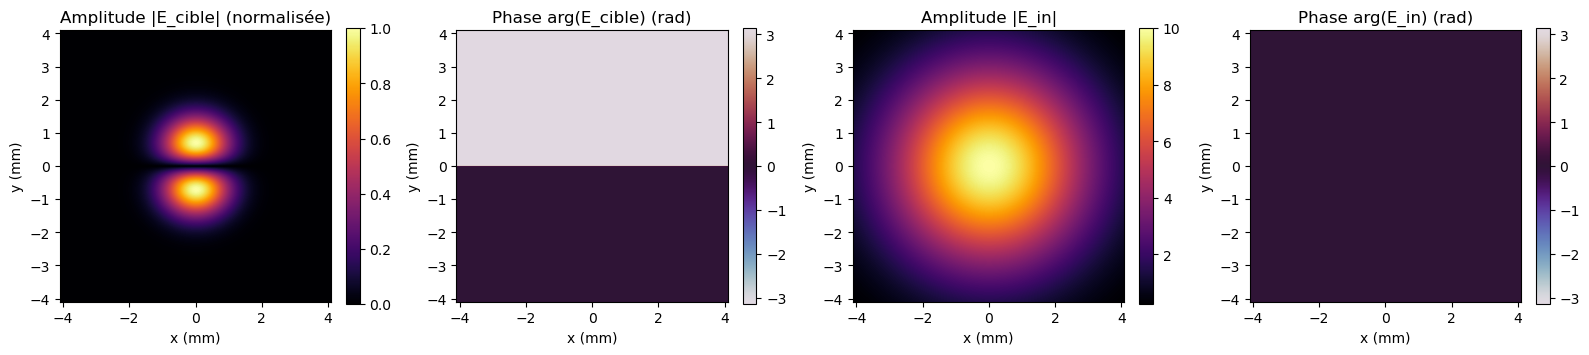

In [65]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import genlaguerre  # LG modes
from scipy.special import hermite     # Hermite-Gauss modes
from modules.visualisation import look_for_spot_Fspace
from scipy.ndimage import gaussian_filter

# ---------- 0. PARAMÈTRES ----------
λ      = 632e-9          # longueur d'onde (m)
k      = 2*np.pi/λ
N      = 1024             # nombre de pixels (NxN)
dx     = 8e-6            # pitch SLM (m)
w0     = 3e-3 
w1 = 1e-3        
Λ      = 3 * dx          # période du réseau (m)
lg_l   = 1               # ordre azimutal LG (exemple)
lg_p   = 0               # ordre radial LG
norm = 10  # normalisation pour ne pas avoir Arel trop grand 
# ---------- 1. GRILLE ----------
x = (np.arange(N) - N/2) * dx
X, Y = np.meshgrid(x, x)
R2   = X**2 + Y**2

# ---------- 2. FAISCEAU INCIDENT mode TEM00 ----------


Ein = norm*np.exp(-R2 / w0**2)*np.exp(0*1j)




"""   # ---------- 3. MODE CIBLE (LG) ----------
r    = np.sqrt(R2)
phi  = np.arctan2(Y, X)
wz   = w0  # on néglige la propagation pour l'exemple
rho  = np.sqrt(2) * r / wz
LG   = (rho**abs(lg_l)) * np.exp(-rho**2/2) \
     * genlaguerre(lg_p, abs(lg_l))(rho**2) \
     * np.exp(1j * lg_l * phi)
Edes = LG / LG.max()          # normalisation
Ades, Phides = np.abs(Edes), np.angle(Edes)  
 """

  # ---------- 3. MODE CIBLE (TEM Hermite‑Gauss) ----------
m, n = 0, 1      # ex. TEM01  (mettre 0,0 pour TEM00)

# coordonnées normalisées
xi  = np.sqrt(2) * X / w1
eta = np.sqrt(2) * Y / w1

# polynômes d'Hermite
Hm  = hermite(m)(xi)
Hn  = hermite(n)(eta)
Edes = Hm * Hn * np.exp(-(xi**2 + eta**2)/2)
Edes /= np.max(np.abs(Edes))
Ades  = np.abs(Edes)
Phides = np.angle(Edes)              # devrait être 0 ou π (réel ±)


# seuil minimum pour ne jamais diviser par ~0
eps = 1e-3 * Ein.max()

# 1) Safe copy d'Ein
Ein_safe = Ein.copy()
Ein_safe[Ein_safe < eps] = eps

# 2) Champ relatif complet (amplitude+phase)
Erel = Edes / Ein_safe

# 3) Extraire amplitude et phase sans jamais faire 0/0
Arel   = np.clip(np.abs(Erel), 0.0, 1.0)
Arel_smooth = gaussian_filter(Arel, sigma=1)    # on borne à 1 si petite sur-modulation
Phirel = np.angle(Erel)                # phase relative (0, 2π)

# RÉSEAU phi_g - déphase sur les x mais pas les y
Phig = (2*np.pi/Λ) * X                  # rampe linéaire
          
Phig = np.mod(Phig , 2*np.pi)  # rampe linéaire (sawtooth)




# Échelle en millimètres pour un repère lisible
extent_mm = [x[0]*1e3, x[-1]*1e3, x[0]*1e3, x[-1]*1e3]

fig, ax = plt.subplots(1,4 , figsize=(16 , 8))

# 1. Amplitude
im0 = ax[0].imshow(Ades, cmap='inferno', extent=extent_mm)
ax[0].set_title('Amplitude |E_cible| (normalisée)')
ax[0].set_xlabel('x (mm)'); ax[0].set_ylabel('y (mm)')
plt.colorbar(im0, ax=ax[0], fraction=0.046)

# 2. Phase
im1 = ax[1].imshow(Phides, cmap='twilight', extent=extent_mm,
                   vmin=-np.pi, vmax=np.pi)
ax[1].set_title('Phase arg(E_cible) (rad)')
ax[1].set_xlabel('x (mm)'); ax[1].set_ylabel('y (mm)')
plt.colorbar(im1, ax=ax[1], fraction=0.046)

# Amplitude de Ein
im2 = ax[2].imshow(np.abs(Ein),
                   cmap='inferno',
                   extent=extent_mm,
                   origin='lower')
ax[2].set_title('Amplitude |E_in|')
ax[2].set_xlabel('x (mm)'); ax[2].set_ylabel('y (mm)')
plt.colorbar(im2, ax=ax[2], fraction=0.046)

# Phase de Ein
im3 = ax[3].imshow(np.angle(Ein),
                   cmap='twilight',
                   extent=extent_mm,
                   vmin=-np.pi, vmax=np.pi,
                   origin='lower')
ax[3].set_title('Phase arg(E_in) (rad)')
ax[3].set_xlabel('x (mm)'); ax[3].set_ylabel('y (mm)')
plt.colorbar(im3, ax=ax[3], fraction=0.046)

plt.tight_layout()
plt.show()

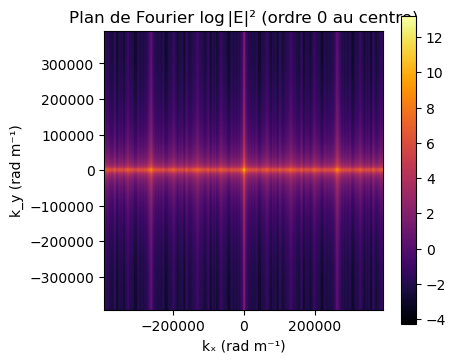

kx0= 260776.73394055903


In [ ]:

#  phase totale périodique [0,2π[
phirelg =(Phirel + Phig)

# méthode A : profondeur = Arel × phirelg
H = (Arel * phirelg)  # phase totale [0,2π[

#  passage au SLM
SLM = np.exp(1j * H)



E0 = Ein * SLM


Ef = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(E0)))


dk  = 2*np.pi / (N*dx)                     # pas spectral
kx  = np.fft.fftshift(np.fft.fftfreq(N, d=dx)) * 2*np.pi   # vecteur 1‑D
extent_k = [kx[0], kx[-1], kx[0], kx[-1]]  # pour imshow

# Exemple d’affichage (ordre 0 au centre (0,0)) :
plt.figure(figsize=(4.5,4))
plt.imshow(np.log10(np.abs(Ef)**2),
           extent=extent_k, origin='lower', cmap='inferno')
plt.xlabel('kₓ (rad m⁻¹)'); plt.ylabel('k_y (rad m⁻¹)')
plt.title('Plan de Fourier log |E|² (ordre 0 au centre)')
plt.colorbar(); plt.show()

# ---------- 9. FILTRE SPATIAL (ordre +1) ----------
# détection automatique du spot (+1 ou –1)
xc, yc = look_for_spot_Fspace(Ef, central_cut=40, side='right')

# diaphragme circulaire 
Rmask = 100
Yg, Xg = np.ogrid[:N, :N]
mask = (Yg - yc)**2 + (Xg - xc)**2 < Rmask**2
Ef_masked = Ef * mask 

r = np.sqrt((Xg - xc)**2 + (Yg - yc)**2) 





Eimg  = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(Ef)))

# retrait du tilt associé au décalage kx0
kx0_pix = xc - N//2
kx0     = kx0_pix * dk
print('kx0=', kx0)
Eimg   *= np.exp(-1j * kx0 * X)  
  
Iimg = np.abs(Eimg)**2






RMS erreur amplitude : 0.3670
RMS erreur phase     : 1.8136 rad


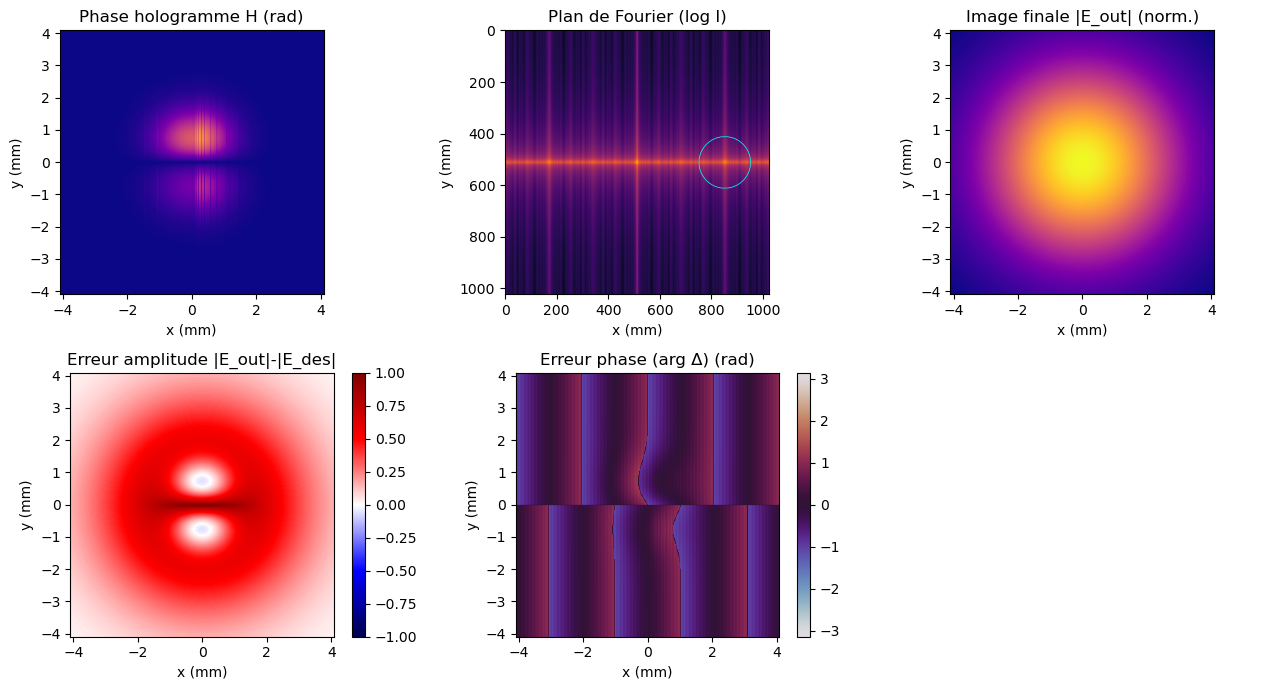

In [79]:



# amplitude (normalisées sur leur max)
Amp_des  = np.abs(Edes) / np.abs(Edes).max()
Amp_out  = np.abs(Eimg) / np.abs(Eimg).max()
Amp_err  = Amp_out - Amp_des             


Ph_des   = np.angle(Edes)
Ph_out   = np.angle(Eimg)
# différence de phase
Ph_diff = np.angle(np.exp(1j*(np.angle(Eimg) - np.angle(Edes))))

# Calcul RMS
rms_amp_err = np.sqrt(np.mean(Amp_err**2))
rms_ph_err  = np.sqrt(np.mean(Ph_diff**2))


print(f"RMS erreur amplitude : {rms_amp_err:.4f}")
print(f"RMS erreur phase     : {rms_ph_err:.4f} rad")

#plots
fig, axs = plt.subplots(2, 3, figsize=(13, 7))


axs[0,0].imshow(H, cmap='plasma', extent=[x[0]*1e3, x[-1]*1e3]*2)
axs[0,0].set_title('Phase hologramme H (rad)')

axs[0,1].imshow(np.log10(np.abs(Ef)**2), cmap='inferno')
axs[0,1].contour(mask, colors='cyan', linewidths=0.5)
axs[0,1].set_title('Plan de Fourier (log I)')
axs[0,1].set_xlabel('fₓ (m⁻¹)'); axs[0,1].set_ylabel('f_y (m⁻¹)')

axs[0,2].imshow(Amp_out, cmap='plasma',
                extent=[x[0]*1e3, x[-1]*1e3]*2)
axs[0,2].set_title('Image finale |E_out| (norm.)')

im3 = axs[1,0].imshow(Amp_err, cmap='seismic', vmin=-1, vmax=1,
                      extent=[x[0]*1e3, x[-1]*1e3]*2)
axs[1,0].set_title('Erreur amplitude |E_out|-|E_des|')
plt.colorbar(im3, ax=axs[1,0], fraction=0.046)

im4 = axs[1,1].imshow(Ph_diff, cmap='twilight',
                      vmin=-np.pi, vmax=np.pi,
                      extent=[x[0]*1e3, x[-1]*1e3]*2)
axs[1,1].set_title('Erreur phase (arg Δ) (rad)')
plt.colorbar(im4, ax=axs[1,1], fraction=0.046)


axs[1,2].axis('off')


for ax in axs.flatten()[:-1]:           # sauf la case blanche
    ax.set_xlabel('x (mm)'); ax.set_ylabel('y (mm)')

plt.tight_layout()
plt.show()
